# Quadgrid
The `quadgrid` package provides a class and some convenience functions 
for generating quadtree-based grids at arbitrary resolutions in pandas, geopandas and xarray formats for use in geospatial analysis and catastrophe risk modelling. 

## Overview
Quadtree grids are a way of recursively partitioning a plane into
nested quadrants, allowing for simple but efficient geocoding of
points.

Some assumptions have been made to simplify the package:
- all coordinates are in decimal degrees
- all longitudes range from -180 to +180 degrees
- the centre of the grid is at 0E, 0N

The package contains a single class, `QuadGrid`, which is used to
generate grid objects. The class has methods to convert the grid into
tabular (pandas DataFrame), vector (geopandas GeoDataFrame) and raster
(xarray Dataset) formats which can be saved or used in further processing.

Individual quadcells at a given resolution are labelled with unique
quadtreeIDs (qids). In the simplified example below, the red point is in top-level cell '2', then cell '2', then '0' then '3' giving a nominal qid of '2203'. In practice, quadtrees lend themselves to a base-4 encoding, allowing them to be stored and processed efficiently as integers.

![image.png](quadgrid.png)

## Examples

In [1]:
import quadgrid as qg
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets as gds

Load shapefiles for examples.

In [2]:
path = gds.get_path('naturalearth.land')
world = gpd.read_file(path)
world.head(2)

,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.1276 -79...."


In [3]:
path = gds.get_path('abs.australia')
aus = gpd.read_file(path)
aus.head(2)

,AUS_CODE21,AUS_NAME21,CHG_FLAG21,CHG_LBL21,AREASQKM21,LOCI_URI21,geometry
0,AUS,Australia,0,No change,7.688095e+06,http://linked.data.gov.au/dataset/asgsed3/AUS/AUS,"MULTIPOLYGON (((96.91524 -12.15313, 96.91523 -..."
1,ZZZ,Outside Australia,1,New,NaN,http://linked.data.gov.au/dataset/asgsed3/AUS/ZZZ,None


### Global low-resolution grid

Create global quadgrid at 2.0$^{\circ}$ resolution:

In [4]:
qg_world = qg.QuadGrid(2)
qg_world

QuadGrid(2°) | -180°<=lon<=180° | -90°<=lat<=90°

Apply a shapely geometry object (either a geopandas GeoDataFrame or shapely [Multi]Polygon) as a mask - note how the mask column changes:

In [5]:
qg_world.apply_mask(gdf=world)

In [6]:
qg_world.grid

,lat,lon,qid,area,mask,res,geometry
0,-89.0,-179.0,40369,863.106049,True,2,"POLYGON ((-178 -88, -180 -88, -180 -90, -178 -..."
1,-89.0,-177.0,40368,863.106049,True,2,"POLYGON ((-176 -88, -178 -88, -178 -90, -176 -..."
2,-89.0,-175.0,40421,863.106049,True,2,"POLYGON ((-174 -88, -176 -88, -176 -90, -174 -..."
3,-89.0,-173.0,40420,863.106049,True,2,"POLYGON ((-172 -88, -174 -88, -174 -90, -172 -..."
4,-89.0,-171.0,40417,863.106049,True,2,"POLYGON ((-170 -88, -172 -88, -172 -90, -170 -..."
...,...,...,...,...,...,...,...
16195,89.0,171.0,14155,863.106049,False,2,"POLYGON ((172 90, 170 90, 170 88, 172 88, 172 ..."
16196,89.0,173.0,14158,863.106049,False,2,"POLYGON ((174 90, 172 90, 172 88, 174 88, 174 ..."
16197,89.0,175.0,14159,863.106049,False,2,"POLYGON ((176 90, 174 90, 174 88, 176 88, 176 ..."
16198,89.0,177.0,14106,863.106049,False,2,"POLYGON ((178 90, 176 90, 176 88, 178 88, 178 ..."


Visualise the grid:

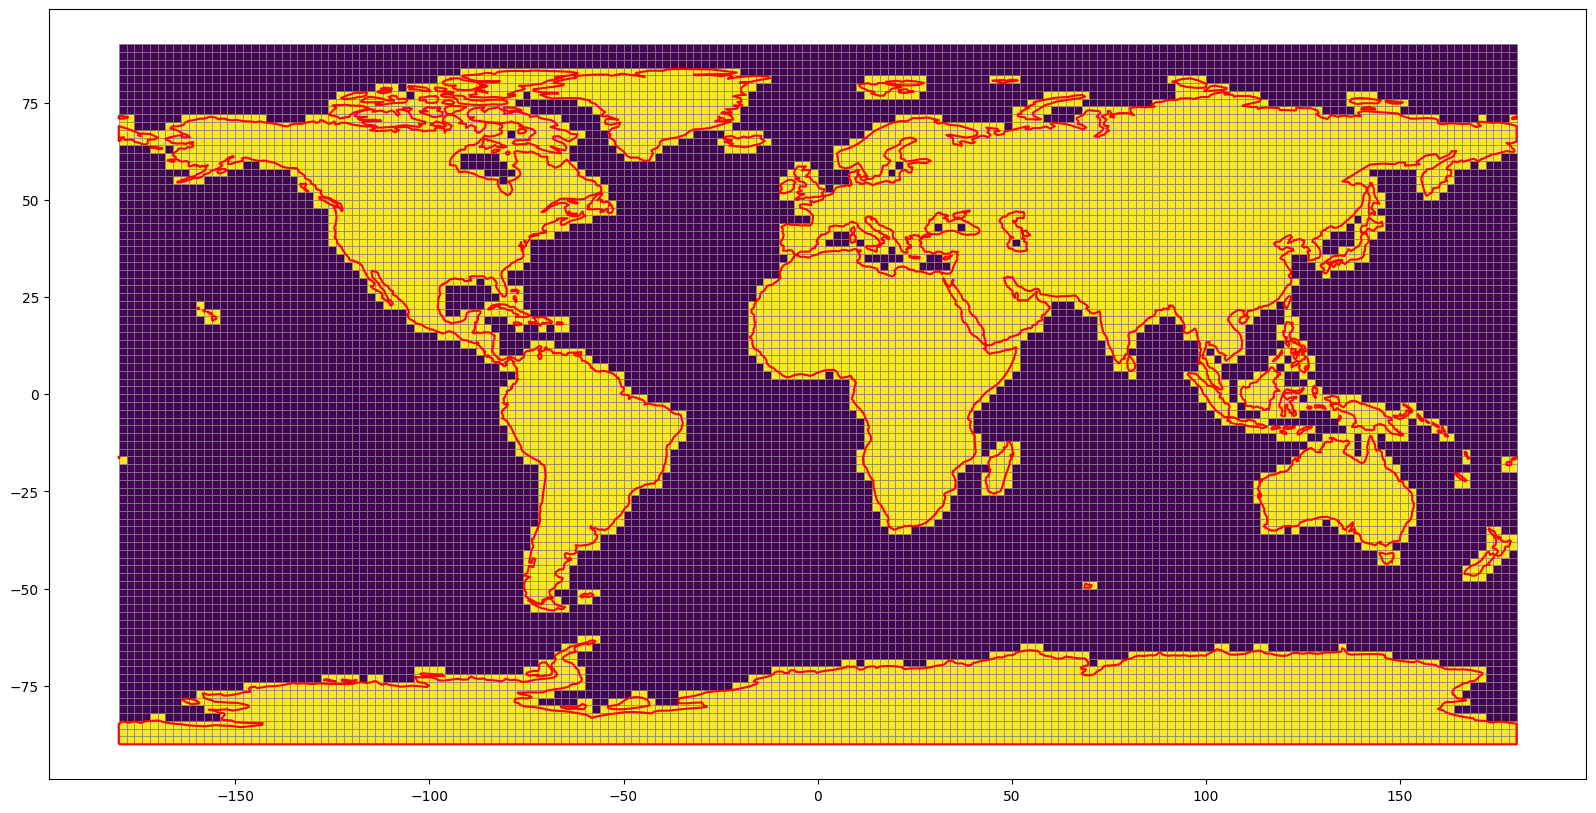

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
qg_world.grid.plot(column='mask', cmap='viridis', edgecolor='0.5', lw=0.5, ax=ax)
world.boundary.plot(color='r', ax=ax);

Convert to xarray:

In [8]:
qg_world_xr = qg_world.to_xarray()
qg_world_xr

<xarray.Dataset> Size: 407kB
Dimensions:  (lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Data variables:
    qid      (lat, lon) int64 130kB 40369 40368 40421 ... 14159 14106 14107
    area     (lat, lon) float64 130kB 863.1 863.1 863.1 ... 863.1 863.1 863.1
    mask     (lat, lon) bool 16kB True True True True ... False False False
    res      (lat, lon) int64 130kB 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2
Attributes:
    Resolution:  2°
    Area units:  km2

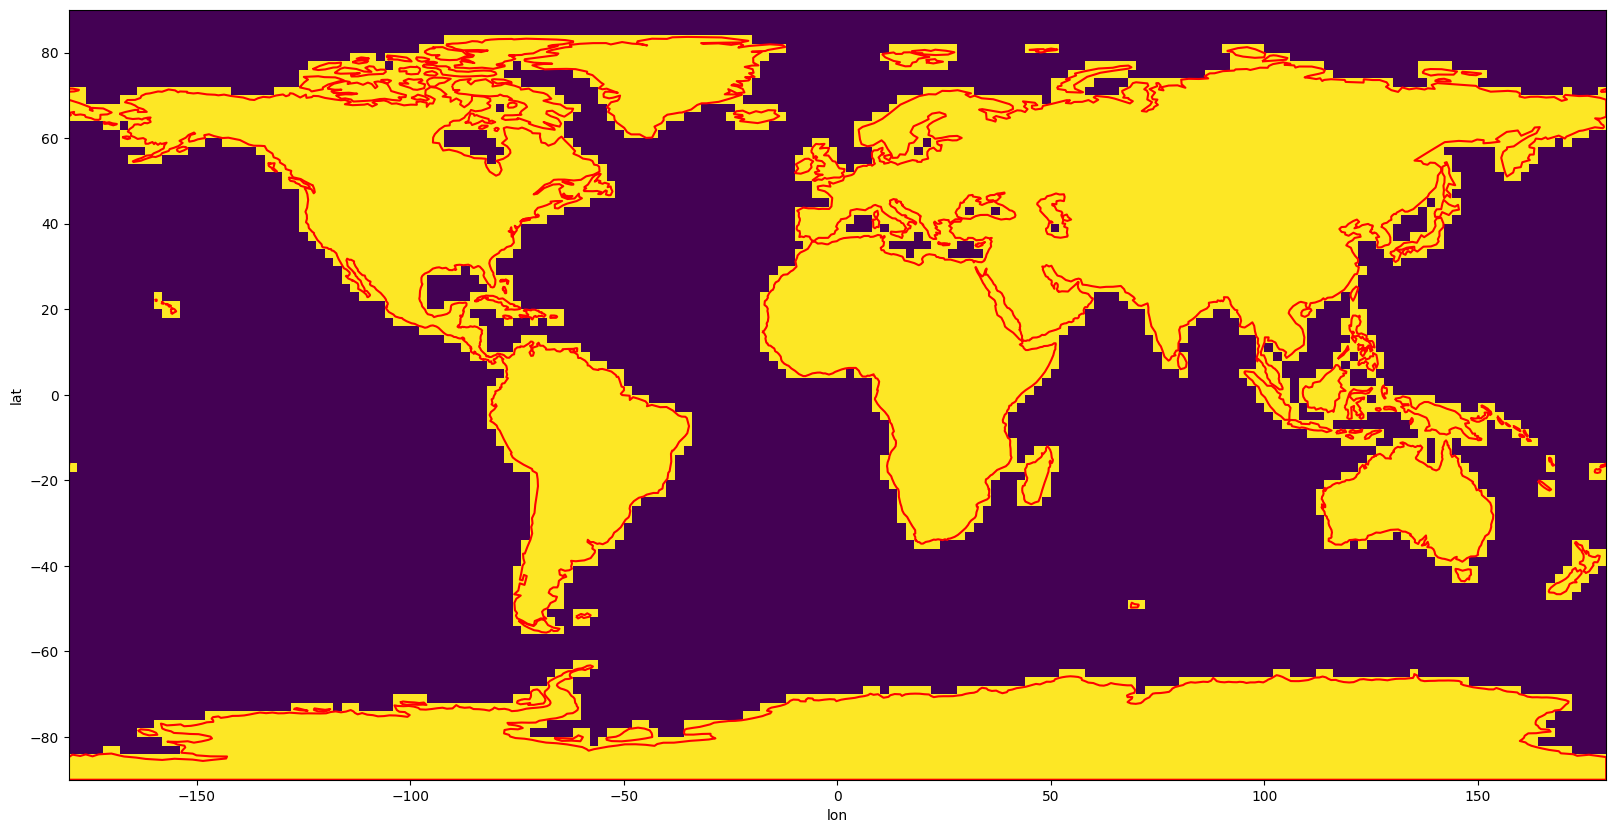

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
qg_world_xr['mask'].plot(add_colorbar=False);
world.boundary.plot(ax=ax, color='r');

### Australia medium-resolution grid

Make a regional grid over Australia at 0.5$^{\circ}$ resolution:

In [10]:
qg_Aus = qg.QuadGrid(0.5, lon_bounds=(96, 168), lat_bounds=(-45, -8))
qg_Aus

QuadGrid(0.5°) | 96°<=lon<=168° | -45°<=lat<=-8°

In [11]:
qg_Aus.grid

,lat,lon,qid,area,mask,res,geometry
0,-44.75,96.25,865942,2195.236198,True,0.5,"POLYGON ((96.5 -44.5, 96 -44.5, 96 -45, 96.5 -..."
1,-44.75,96.75,865943,2195.236198,True,0.5,"POLYGON ((97 -44.5, 96.5 -44.5, 96.5 -45, 97 -..."
2,-44.75,97.25,865938,2195.236198,True,0.5,"POLYGON ((97.5 -44.5, 97 -44.5, 97 -45, 97.5 -..."
3,-44.75,97.75,865939,2195.236198,True,0.5,"POLYGON ((98 -44.5, 97.5 -44.5, 97.5 -45, 98 -..."
4,-44.75,98.25,865926,2195.236198,True,0.5,"POLYGON ((98.5 -44.5, 98 -44.5, 98 -45, 98.5 -..."
...,...,...,...,...,...,...,...
10651,-8.25,165.75,804368,3059.086574,True,0.5,"POLYGON ((166 -8, 165.5 -8, 165.5 -8.5, 166 -8..."
10652,-8.25,166.25,804357,3059.086574,True,0.5,"POLYGON ((166.5 -8, 166 -8, 166 -8.5, 166.5 -8..."
10653,-8.25,166.75,804356,3059.086574,True,0.5,"POLYGON ((167 -8, 166.5 -8, 166.5 -8.5, 167 -8..."
10654,-8.25,167.25,804353,3059.086574,True,0.5,"POLYGON ((167.5 -8, 167 -8, 167 -8.5, 167.5 -8..."


Apply the country mask:

In [12]:
qg_Aus.apply_mask(aus)

Visualise:

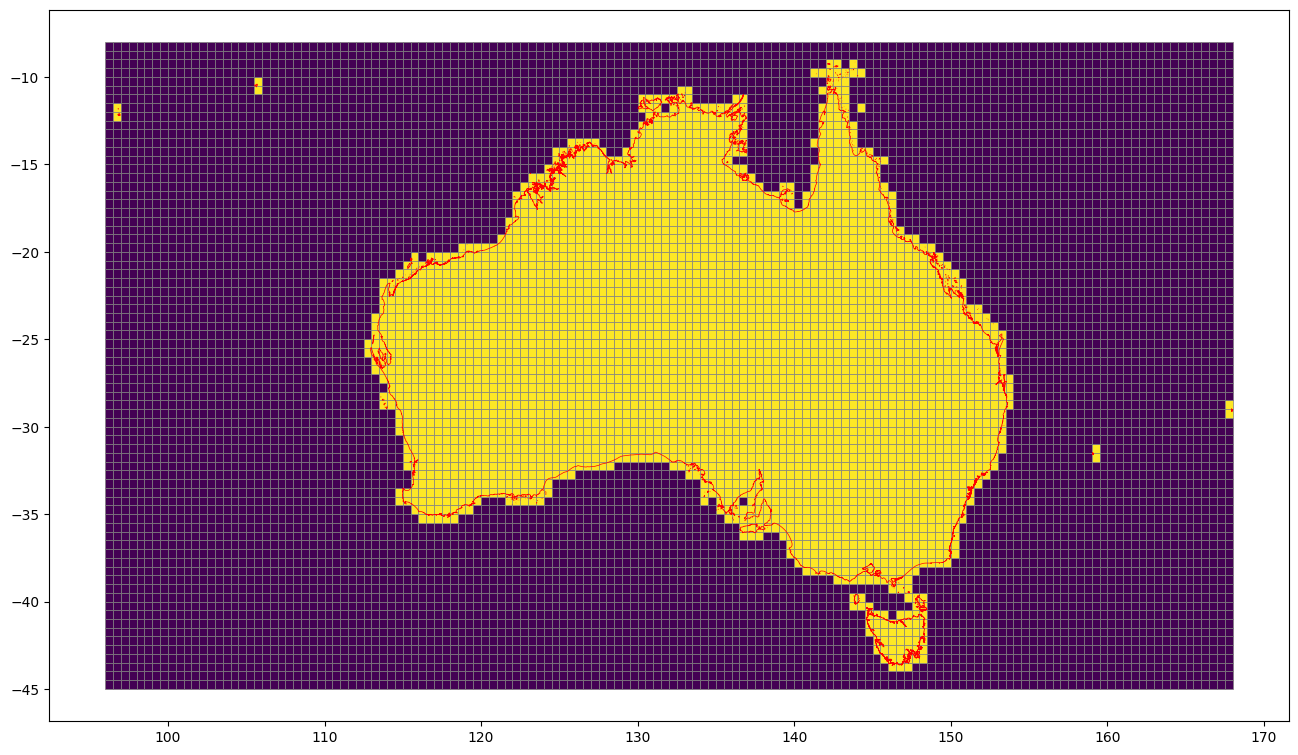

In [13]:
fig, ax = plt.subplots(1,1, figsize=(16,12))
qg_Aus.grid.plot(column='mask', cmap='viridis', edgecolor='0.5', lw=0.5, ax=ax)
aus.boundary.plot(ax=ax, color='r', lw=0.5);

### Querying points

The `query()` method looks up the quadtreeID (qids) of longitude and latitude pairs.

In [14]:
n = 100
lons = np.random.uniform(96, 168, n)
lats = np.random.uniform(-43, -9, n)

In [15]:
qg_Aus.query(lons, lats)

array([865677, 816442, 810175, 805631, 808887, 810116, 865313, 816598,
       810174, 810125, 816449, 811354, 809514, 809687, 804516, 812191,
       807653, 807870, 865408, 810004, 811790, 807820, 811422, 810951,
       855669, 809079, 865809, 865121, 864562, 865074, 864748, 809666,
       804414, 807894, 854867, 812297, 810810, 854133, 805287, 811474,
       809338, 812800, 812197, 810605, 865564, 811090, 865549, 852884,
       854594, 811602, 810388, 865369, 855992, 864286, 810780, 816611,
       809538, 855988, 855241, 855822, 865685, 811288, 810076, 864675,
       811235, 811585, 810476, 854621, 810290, 810104, 865631, 805606,
       812089, 854142, 809692, 808577, 811082, 805132, 808586, 816664,
       809996, 809940, 810866, 811468, 810438, 809357, 809543, 809678,
       854849, 811409, 855273, 809515, 852961, 865319, 808681, 810467,
       855039, 865842, 809327, 809246])

### Distance operations

The `distance()` method calculates the distances from a single point to all grid centroids. For example, the following calculates the distances from Uluru of all quadcells on the Australia subgrid.

In [16]:
uluru_lonlat = 131.035085, -25.345152
dist = qg_Aus.distance(*uluru_lonlat)
dist

lat     lon   
-44.75  96.25     3786.767357
        96.75     3750.489540
        97.25     3714.367013
        97.75     3678.405417
        98.25     3642.610577
                     ...     
-8.25   165.75    4135.588650
        166.25    4182.503020
        166.75    4229.548638
        167.25    4276.720809
        167.75    4324.015025
Name: distance_km, Length: 10656, dtype: float64

Convert to xarray and use the xarray version of the Australia mask to filter out non-land, then plot:

In [17]:
dist_da = dist.to_xarray()

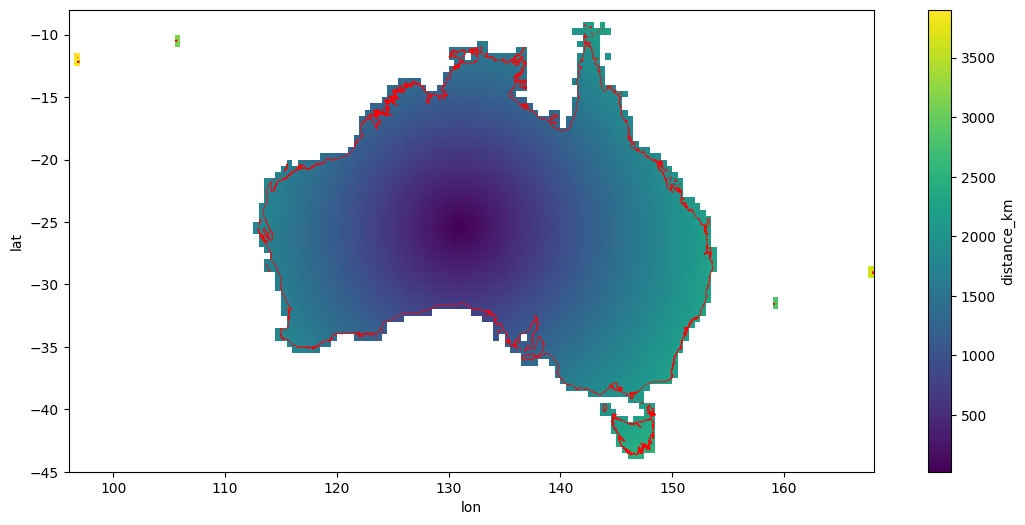

In [18]:
fig, ax = plt.subplots(figsize=(14,6))
dist_da.where(qg_Aus.to_xarray()['mask']).plot(ax=ax)
aus.boundary.plot(ax=ax, color='r', lw=0.5);